In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt

import pyrr
import itertools

#basedir = os.path.dirname("/mnt/sda/Github/LiDAR/")
basedir = os.path.abspath(os.path.join(os.getcwd() ,"../"))
_py = os.path.join(basedir, 'py')
_data = os.path.join(basedir, 'data')
print(basedir)
print(_py)
sys.path.insert(1, _py)
print(sys.path)
import loads 
import lia
import ray as rayt
import lad
import figures

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2


/mnt/sda/Github/LiDAR
/mnt/sda/Github/LiDAR/py
['/mnt/sda/Github/LiDAR/nb', '/mnt/sda/Github/LiDAR/py', '/home/jzhu/miniconda3/envs/plant-env/lib/python38.zip', '/home/jzhu/miniconda3/envs/plant-env/lib/python3.8', '/home/jzhu/miniconda3/envs/plant-env/lib/python3.8/lib-dynload', '', '/home/jzhu/miniconda3/envs/plant-env/lib/python3.8/site-packages', '/home/jzhu/miniconda3/envs/plant-env/lib/python3.8/site-packages/IPython/extensions', '/home/jzhu/.ipython']
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
import loads

#loads.ply2npy(mockname="groimp_mock")
loads.csv2npy(mockname="groimp_mock")

GroIMP_PointClouds.csv done --> Number of beams: 120869


In [78]:
from plyfile import PlyData, PlyElement
datapath = os.path.join(_data,"groimp_mock")
file = os.path.join(datapath, 'skiwicanopy.ply')

df1 = PlyData.read(file)
df = np.transpose([df1.elements[0].data['x'],
                    df1.elements[0].data['y'],
                    df1.elements[0].data['z']])
print(df)

[[-16.39697  -8.52318   1.79079]
 [-16.3551   -8.61365   1.79874]
 [-16.30622  -8.48118   1.79079]
 [-16.26435  -8.57164   1.79874]
 [-16.4947   -8.14769   1.71079]
 [-16.4578   -8.15008   1.80371]
 [-16.48826  -8.0479    1.71079]
 [-16.45136  -8.05028   1.80371]
 [-16.65464  -7.7528    1.83679]
 [-16.73903  -7.79221   1.87318]
 [-16.61232  -7.8434    1.83679]
 [-16.69672  -7.88282   1.87318]
 [-17.01766  -8.32375   1.66179]
 [-16.94083  -8.38693   1.67211]
 [-16.95414  -8.24652   1.66179]
 [-16.87731  -8.3097    1.67211]
 [-16.79543  -8.30323   1.77179]
 [-16.87608  -8.24835   1.79378]
 [-16.85168  -8.3859    1.77179]
 [-16.93234  -8.33102   1.79378]
 [-16.91643  -8.168     1.69479]
 [-16.96889  -8.17926   1.77918]
 [-16.89545  -8.26577   1.69479]
 [-16.94791  -8.27703   1.77918]
 [-17.12974  -7.70966   1.75979]
 [-17.08376  -7.74013   1.8432 ]
 [-17.0745   -7.6263    1.75979]
 [-17.02852  -7.65678   1.8432 ]
 [-16.47372  -8.17275   1.88679]
 [-16.47536  -8.24326   1.95769]
 [-16.3737

In [6]:
from numpy import genfromtxt
datapath = os.path.join(_data,"groimp_mock")
file = os.path.join(datapath, 'GroIMP_PointClouds.csv')
#df = np.genfromtxt(file, delimiter=',', encoding=None, names=True,
#    dtype= float)
df = np.loadtxt(file, delimiter=',', 
                dtype={'names':('x', 'y', 'z'),
                'formats':('f4', 'f4', 'f4')})
print(df[0])
print(file)

#np.genfromtxt(txt, delimiter=',', names=True, dtype=None, encoding=None)



(-16.2226, -7.971, 1.8803)
/mnt/sda/Github/LiDAR/data/groimp_mock/GroIMP_PointClouds.csv


In [7]:
print(df[0][1])

-7.971


In [8]:
import pandas as pd
datapath = os.path.join(_data,"groimp_mock")
file = os.path.join(datapath, 'Groimp_PointClouds.csv')

df=pd.read_csv(file, sep=',' ,usecols=['x', 'y','z'])


print(df)


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/sda/Github/LiDAR/data/groimp_mock/Groimp_PointClouds.csv'

If `downsample` is not None, a random downsampling will be implemented. If None, the pipeline will use the voxel-based downsampling.

In [9]:
mockname = 'groimp_mock'
voxel_size = 0.1
downsample = 1

In [10]:
mockname

'groimp_mock'

## Tree and leaves segmentation

Now we create the module to segmentate trees. This will be tuned acordingly for each data set, so below module only works for this particular data set.

In [19]:
def segtree(df, leaves, show=False):

    trees = {}

    if show:
        plt.figure(figsize=(14, 8))

    # centres
    x, y = [-16.6], [-8.16]
    num = 0
    dx, dy = 20, 10
    # dx, dy = 5, 5

    for i in x:
        for j in y:
            
            keep = np.ones(len(df['x']), dtype=bool)
            #keep &= (df['x'] < i+dx) & (df['x'] > i-dx)
            #keep &= (df['y'] < j+dy) & (df['y'] > j-dy)

            trees['tree_%s' %(str(num))] = keep
            
            if show:
                plt.scatter(df['x'][leaves & keep], df['y'][leaves & keep], s=0.5, label=num)
                        
            num += 1

    if show:
        plt.legend()
    
    return trees


We segmentate the trees below,

In [31]:
# load data into a pandas data frame
df = loads.plynpy2pandas(mockname)
N = len(df)

#print(df['z'])

Number of files: 1


In [32]:

def voxel_subsampling(voxel_size, POINTS):

    nb_vox = np.ceil((np.max(POINTS, axis=0) - np.min(POINTS, axis=0))/voxel_size)
    ni, nj, nk = nb_vox
    print('min point:', np.min(POINTS, axis=0))
    print('max point:', np.max(POINTS, axis=0))
    print('Number of voxels: i:%d, j:%d, k:%d --> Total: %d' %(ni, nj, nk, np.product(nb_vox)))

    non_empty_voxel_keys, inverse, nb_pts_per_voxel = np.unique(((POINTS - np.min(POINTS, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
    idx_pts_vox_sorted = np.argsort(inverse)
    print('Number of non-empty voxels: %d' %(len(non_empty_voxel_keys)))

    voxel_grid={}
    voxel_grid_ptsidx = {}
    grid_barycenter,grid_candidate_center = [], []
    last_seen=0

    for idx, vox in enumerate(non_empty_voxel_keys):

        idxs_per_vox = idx_pts_vox_sorted[last_seen:last_seen+nb_pts_per_voxel[idx]]
        voxel_grid[tuple(vox)] = POINTS[idxs_per_vox]
        voxel_grid_ptsidx[tuple(vox)] = idxs_per_vox

        # grid_barycenter.append(np.mean(voxel_grid[tuple(vox)],axis=0))

        idx_grid_candidate_center = np.linalg.norm(voxel_grid[tuple(vox)] - np.mean(voxel_grid[tuple(vox)],axis=0),axis=1).argmin()
        grid_candidate_center.append(voxel_grid_ptsidx[tuple(vox)][idx_grid_candidate_center])

        last_seen+=nb_pts_per_voxel[idx]

    # print('Downsampling percentage: %.1f %%' %(100 * len(grid_candidate_center) / len(POINTS)))
    # minpoint = np.min(POINTS, axis=0)

    return list(grid_candidate_center) #, minpoint

In [33]:
def random_downsample(N, downsample):

    resdir = os.path.join(_data, mockname, 'random_%s' %(str(downsample)))
    if not os.path.exists(resdir):
        os.makedirs(resdir)

    outdir = os.path.join(resdir, 'inds.npy')
    if os.path.exists(outdir):
        print('inds file already exists for donwnsample of %.3f at %s' %(downsample, outdir))

        idx = np.load(outdir)

    else:

        print('inds not been created yet for donwnsample of %.3f' %(downsample))
        idx = np.random.randint(0, N, int(N * downsample))
        # inds = np.zeros(N, dtype=bool)
        # inds[idx] = True

        np.save(outdir, idx)

    return idx

### Implement and keep Downsamplied points

In [34]:

if downsample is not None:
    inds = random_downsample(N, downsample)
else:
    inds = voxel_subsampling(voxel_size, df[['x', 'y', 'z']].to_numpy())

print('Downsampling percentage: %.1f %%' %(100 *  len(inds) / len(df['x'])))

df = df.iloc[inds]
POINTS = df[['x', 'y', 'z']].to_numpy()
SENSORS = df[['sx', 'sy', 'sz']].to_numpy()

# Compute lower point
minpoint = np.min(POINTS, axis=0)
print('minpoint:', minpoint)



inds file already exists for donwnsample of 1.000 at /mnt/sda/Github/LiDAR/data/groimp_mock/random_1/inds.npy
Downsampling percentage: 0.2 %
minpoint: [-17.5171  -8.7197   1.4659]


### leave and tree segmentation

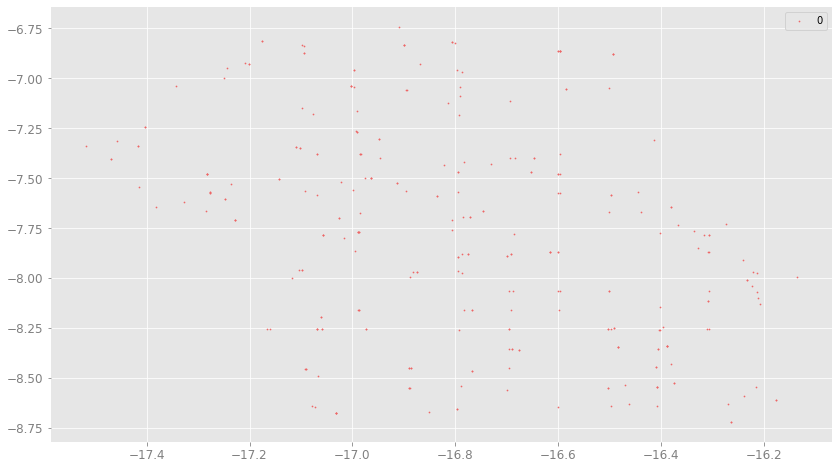

In [35]:
# extract leaves. Boolean array output
leaves = loads.extract_leaves_2(df, show=False)

# extract trees. Dictionary with boolean arrays output
trees = segtree(df, leaves, show=True)


### Second downsampling: keep only points that colide with Plant Region

In [36]:
inPR = (leaves) & (trees['tree_0'])
minBB, maxBB = np.min(POINTS[inPR], axis=0), np.max(POINTS[inPR], axis=0)
print(minBB, maxBB)

[-17.5171  -8.7197   1.4659] [-16.1372  -6.7413   2.0001]


In [37]:
minBB, maxBB = np.min(POINTS[inPR], axis=0), np.max(POINTS[inPR], axis=0)

# Make sure Plant Region min & max points are multiples of voxel size
# to match first voxelization where we implemented the downsampling
minpointPR = minpoint + np.floor(np.abs(minpoint - minBB)/voxel_size) * voxel_size
maxpointPR = minpoint + np.ceil(np.abs(minpoint - maxBB)/voxel_size) * voxel_size
boxPR = pyrr.aabb.create_from_bounds(minpointPR, maxpointPR)

lines = np.stack((POINTS, SENSORS), axis=1)
f = lambda line: pyrr.geometric_tests.ray_intersect_aabb(pyrr.ray.create_from_line(line), boxPR) is not None
res = np.array(list(map(f, lines)))

In [38]:
POINTS, SENSORS = POINTS[res], SENSORS[res]

leaves = leaves[res]

for key, val in trees.items():
    trees[key] = val[res]

In [39]:
# save indexes of voxel-based downsample

idxs = np.array(inds)[res]

if downsample is not None:
    dirname = 'random_%s' %(str(downsample))
    resdir = os.path.join(_data, mockname, dirname, 'lad_%s' %(str(voxel_size)))
else:
    dirname = 'voxel'
    resdir = os.path.join(_data, mockname, dirname, 'lad_%s' %(str(voxel_size)))

if not os.path.exists(resdir): os.makedirs(resdir)
outdir = os.path.join(resdir, 'inds.npy')
np.save(outdir, idxs)

## Ray tracing

In [40]:
sample = None

inPR = (leaves) & (trees['tree_0'])

# resdir = os.path.join(_data, mockname, 'lad_%s' %(str(voxel_size)))
# if not os.path.exists(resdir):
    # os.makedirs(resdir)
if sample is not None:
    print('# iter...', len(POINTS[::sample]))
    m3s = rayt.main2(POINTS[::sample], SENSORS[::sample], POINTS[inPR], voxel_size, resdir, 'tree_0', (minpointPR, maxpointPR), show=True)
else:
    print('# iter...', len(POINTS))
    m3s = rayt.main2(POINTS, SENSORS, POINTS[inPR], voxel_size, resdir, 'tree_0', (minpointPR, maxpointPR), show=False)

# iter... 300


300it [00:01, 193.53it/s]

tot vox: 	 1680
voxels hitted: 	 298
Percentage of voxels hitted by beam: 0.18
voxels hitted (OLD): 	 0
Percentage of voxels hitted by beam (OLD): 0.00


In [41]:
POINTS[inPR]

array([[-16.6   ,  -7.4778,   1.7549],
       [-17.0698,  -7.5824,   1.8508],
       [-16.4913,  -8.2478,   1.7986],
       [-17.5171,  -7.3359,   1.6355],
       [-16.9879,  -7.7682,   1.7438],
       [-16.4039,  -8.2582,   1.6788],
       [-17.2291,  -7.7079,   1.7049],
       [-16.6468,  -7.4007,   1.8745],
       [-16.8067,  -7.7569,   1.5875],
       [-16.6   ,  -7.8697,   1.7612],
       [-17.0263,  -7.6981,   1.7245],
       [-17.0681,  -8.2538,   1.9216],
       [-16.8068,  -6.8193,   1.5855],
       [-16.3893,  -8.339 ,   1.7324],
       [-16.9917,  -7.267 ,   1.7101],
       [-17.0033,  -7.0394,   1.633 ],
       [-16.2392,  -8.5881,   1.8267],
       [-16.767 ,  -8.4638,   1.7691],
       [-17.0582,  -7.7822,   1.9232],
       [-16.7954,  -7.9637,   1.7044],
       [-16.7687,  -8.16  ,   1.9831],
       [-16.9863,  -7.6748,   1.7749],
       [-16.4098,  -8.4457,   1.8372],
       [-16.9641,  -7.4966,   1.9157],
       [-16.485 ,  -8.3447,   1.7675],
       [-17.1766,  -6.810

In [42]:
inPR = (leaves) & (trees['tree_0'])

voxel_size
# resdir = os.path.join(_data, mockname, 'lad_%s' %(str(voxel_size)))
NI, N0, NP0, NP = lad.get_attributes_per_k(POINTS[inPR], voxel_size, (minpointPR, maxpointPR), 'tree_0', kval=2, resdir=resdir, showall=True)

/mnt/sda/Github/LiDAR/data/groimp_mock/random_1/lad_0.1/m3count_tree_0_0.1.npy
[[[0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  ...
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]]

 [[0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  ...
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]]

 [[0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  ...
  [0 0 0 0 2 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]]

 ...

 [[0 0 0 0 3 0]
  [0 0 0 0 0 0]
  [0 0 0 5 0 0]
  ...
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]]

 [[0 0 0 0 0 0]
  [0 0 0 3 0 0]
  [0 0 0 0 0 0]
  ...
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]]

 [[0 0 0 0 0 0]
  [0 0 0 2 0 0]
  [0 0 0 0 0 0]
  ...
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]]]


ValueError: not enough values to unpack (expected 3, got 2)

## LIA

In [70]:
def best_fit_lia(mockname):

    df = loads.npy2pandas(mockname)
    # extract leaves. Boolean array output
    leaves = loads.extract_leaves(df, show=False)
    # extract trees. Dictionary with boolean arrays output
    trees = segtree(df, leaves, show=False)

    for key, val in trees.items():

        keep = (val) & (leaves) # take the LPC per tree
        points = df[['x', 'y', 'z']].to_numpy()[keep]

        res = lia.bestfit_pars_la(points, mockname, treename=key)
        lia.best_fit_pars_plot(res, key, mockname)

In [71]:
def get_lia(mockname):

    df = loads.npy2pandas(mockname)

    # extract leaves. Boolean array output
    leaves = loads.extract_leaves(df, show=False)
    # extract trees. Dictionary with boolean arrays output
    trees = segtree(df, leaves, show=False)


    # load bestfit results
    for key, val in trees.items():

        keep = (val) & (leaves)
        points = df[['x', 'y', 'z']].to_numpy()[keep]
    
        bestfit_file = os.path.join(_data, mockname, 'lia', 'bestfit_%s.npy' %(key))
        res = np.load(bestfit_file, allow_pickle=True)
        res = res.tolist()

        text = 'leaf area=%.2f \n %s=%.4f \n %s=%.4f \n %s=%.4f ' %(res['leafsize'], 'voxel_size_w', res['voxel_size_w_bestfit'],'kd3_sr', res['kd3_sr_bestfit'],'max_nn', res['max_nn_bestfit'])
        print(text)

        chi2 = lia.leaf_angle(points, mockname, key, res['voxel_size_w_bestfit'], 
                                res['kd3_sr_bestfit'], res['max_nn_bestfit'], save=True,
                                    savefig=True, text=text, voxel_size_h=0.1)

        # save indexes from main df
        inds = np.where((val) & (leaves))
        np.save(os.path.join(_data, mockname, 'lia', 'inds.npy'), inds[0])


In [72]:
best_fit_lia(mockname)

Number of files: 0


ValueError: need at least one array to concatenate

In [ ]:
get_lia(mockname)

In [ ]:
inds_file = os.path.join(resdir, 'inds.npy')
inds = np.load(inds_file)
print(inds)

In [ ]:
inds_lia = np.load(os.path.join(_data, mockname, 'lia', 'inds.npy'))
print(inds_lia)

In [ ]:
def runall(pointsPR, sensorsPR, voxel_size, tree, N, PRbounds, resdir, kbins=None):

    # resdir = os.path.join(_data, mockname, 'lad_%s' %(str(voxel_size)))
    inds_file = os.path.join(resdir, 'inds.npy')
    inds = np.load(inds_file)
    print(inds)

    # resdir = os.path.join(_data, mockname, 'lad_%s' %(str(voxel_size)))

    inds_lia = np.load(os.path.join(_data, mockname, 'lia', 'inds.npy'))

    isfigures = os.path.join(resdir, 'figures')
    if not os.path.exists(isfigures):
        os.makedirs(isfigures)

    attributes2_file = os.path.join(resdir, 'm3s_%s_%s.npy' %(tree, str(voxel_size)))
    if os.path.isfile(attributes2_file):
        m3b = np.load(attributes2_file)

    print('voxel_size:', voxel_size)

    m3att = lad.compute_attributes(pointsPR, resdir, voxel_size, tree, PRbounds)

    # _,_,_, m3scount = lad.density_counts(pointsPR, voxel_size)

    # get in down sample boolean array for LPC size
    mask1 = np.zeros(N, bool)
    mask2 = mask1.copy()

    mask1[inds] = True
    mask2[inds_lia] = True

    lias, ws = lad.downsample_lia(mockname, tree, np.where(mask1[mask2])[0])
    voxk = lad.get_voxk(pointsPR, PRbounds, voxel_size)
    bia = lad.get_bia(pointsPR, sensorsPR)
    meshfile = lad.get_meshfile(mockname)

    print('DEBUG')
    print(len(lias), len(ws), len(voxk))

    figext = '%s_%s' %(tree, str(voxel_size))
    # figext = None
    
    alphas_k = lad.alpha_k(bia, voxk, lias, ws, resdir, meshfile, figext=figext, 
                            klia=False, use_true_lia=True)

    kmax = m3b.shape[2]
    if kbins is None:
        kbins = int(kmax/15)
    print(kbins)

    # Attribute 2 counts per voxel
    # outdir_count = os.path.join(resdir, 'm3count_%s_%s.npy' %(tree, str(voxel_size)))
    
    lads_mid, clai = lad.get_LADS2(pointsPR, kmax, voxel_size, kbins, alphas_k[:,6], PRbounds, tree, resdir)
    lads_0, _ = lad.get_LADS2(pointsPR, kmax, voxel_size, kbins, alphas_k[:,6]*0+1, PRbounds, tree, resdir)
    # lads_mid_old, _ = lad.get_LADS2(pointsPR, kmax, voxel_size, kbins, alphas_k[:,6], PRbounds, tree, resdir, oldlad=True)
    # lads_mid_old = lad.get_LADS(m3att, voxel_size, kbins, alphas_k[:,6], alpha2=1)
    lads_mesh = lad.get_LADS_mesh(meshfile, voxel_size, kbins, kmax, PRbounds)

    # lads = {'Truth':lads_mesh, 'Correction Mean':lads_mid, 'No Correction':lads_0, 'Correction Weights':lads_mid_w}#, 'Correction counts':lads_mid_counts}
    lads = {'Truth':lads_mesh, 'Correction Mean':lads_mid, 'No Correction':lads_0}
    # clai = lad.get_clai(m3att, alphas_k)
    attributes_file = os.path.join(resdir, 'm3s_%s_%s.npy' %(tree, str(voxel_size)))
    if os.path.isfile(attributes_file):
        RT = 'Y'
    else:
        RT = 'N'
        
    text = {'tree':tree, 'VS':voxel_size, 'RT':RT, 'CLAI':np.round(clai, 3)}
    txt = []
    for key, val in text.items():
        txt.append('%s=%s \n' %(key, str(val)))
    text = (' ').join(txt)

    savefig = os.path.join(resdir, 'figures','LAD_%s.png' %(figext))
    figures.plot_lads(lads, text, savefig=savefig)


Below issue is related to LIA, `voxk` size is the same as `POINTS[inPR]` of 33145. We have to build an array that has same dimmensions as `POINTS[inPR]` and asociated the LIA values to it.

In [ ]:
len(POINTS[inPR])

In [ ]:
inPR = (leaves) & (trees['tree_0'])
runall(POINTS[inPR], SENSORS[inPR], voxel_size, 'tree_0', N, (minpointPR, maxpointPR), resdir, kbins=1)